In [208]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

## Data Import

In [209]:
#import data
df = pd.read_json('2.News_With_Labels.json')
df.head()

,createdate,articles
0,2019-07-04,"{'publishdate': '1/2/2018', 'content': ' Mor..."
1,2019-07-04,"{'publishdate': '1/2/2018', 'content': 'If Pro..."
2,2019-07-04,"{'publishdate': '1/2/2018', 'content': 'A YouT..."
3,2019-07-04,"{'publishdate': '1/2/2018', 'content': ' Mor..."
4,2019-07-04,"{'publishdate': '1/2/2018', 'content': 'Q. I ..."


In [210]:
df['articles'][1]['title']

'Activists’ Guide to 2018: The Best Defense Is a Good Offense'

In [211]:
#format data into pandas dataframe
stock_df = pd.DataFrame([])

for i in df['articles']:
    #stock_df = stock_df.append(pd.DataFrame({'publish_date': i['publishdate'], 'content': i['content'], 'label': i['label']}, index=[0]), ignore_index=True)
    stock_df = stock_df.append(pd.DataFrame({'content': i['content'], 'label': i['label'],'category':i['category']}, index=[0]), ignore_index=True)

#number of characters
print(f"Number of words in raw data: {stock_df['content'].apply(lambda x: len(x.split(' '))).sum()}") 
stock_df.head()

Number of words in raw data: 4827973


,content,label,category
0,\n\n\nMore on NYTimes.com\n\n\n\n\n,Buy,Technology
1,If Procter & Gamble were sponsoring a 2018 adv...,Buy,Business
2,A YouTube star with millions of followers apol...,Buy,Business
3,\n\n\nMore on NYTimes.com\n\n\n\n\n,Buy,Business Day
4,Q. I see posts in my Twitter feed that have “...,Buy,Business


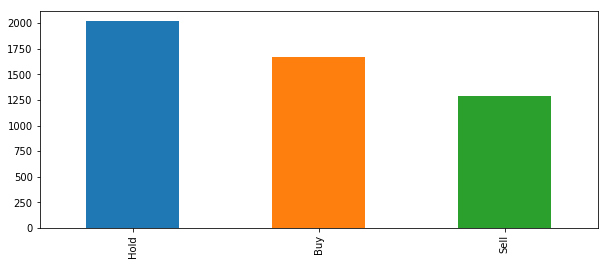

In [212]:
#let's take a look at the label spread
plt.figure(figsize=(10,4))
stock_df.label.value_counts().plot(kind='bar');

Spread looks good!

## Text Pre-Processing:
Remove stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [213]:
import nltk
nltk.download('stopwords')

#clean up the text
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

#function to clean the text
def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text
    
#apply function to each row in the dataframe
stock_df['content'] = stock_df['content'].apply(clean_text)
#number of words after clean up
print(f"Number of words AFTER clean up: {stock_df['content'].apply(lambda x: len(x.split(' '))).sum()}") 
stock_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Number of words AFTER clean up: 2906051


,content,label,category
0,nytimescom,Buy,Technology
1,procter gamble sponsoring 2018 advertisement a...,Buy,Business
2,youtube star millions followers apologized mon...,Buy,Business
3,nytimescom,Buy,Business Day
4,q see posts twitter feed sensitive content lab...,Buy,Business


We were able to cut down the amount of words/characters significantly! (From 5 million to 3 million)

In [214]:
stock_df.loc[stock_df['label']=='Buy','label']='Hold'
stock_df=stock_df.groupby('label').head(stock_df['label'].value_counts().min())

In [215]:
stock_df['label'].value_counts()

Hold    1290
Sell    1290
Name: label, dtype: int64

In [216]:
#Notice some of the rows have little to no content
#delete these rows to avoid error in the model

#keep a count of how many you delete
bad_rows = []
for i in range(0,stock_df.shape[0]):
    #if the number of characters is below 100
    if len(stock_df['content'].iloc[i])<10:
        bad_rows.append(i)

In [161]:
# #drop the rows we found to have fewer than 100 characters
stock_df = stock_df.drop(bad_rows)
#reset index
stock_df = stock_df.reset_index(drop=True)
print(stock_df.shape)
print(stock_df.head())

KeyError: '[3834] not found in axis'

In [217]:
stock_df

,content,label,category
0,nytimescom,Hold,Technology
1,procter gamble sponsoring 2018 advertisement a...,Hold,Business
2,youtube star millions followers apologized mon...,Hold,Business
3,nytimescom,Hold,Business Day
4,q see posts twitter feed sensitive content lab...,Hold,Business
5,golden age television programming heading gris...,Hold,Business
6,please take seatsit time year annual closing d...,Hold,Business
7,hong kong one worlds valuable startups got way...,Hold,Business
8,washington united states officials effectively...,Hold,Business
9,vice media placed president andrew creighton c...,Hold,Business


In [218]:
stock_df['label'].value_counts()

Hold    1290
Sell    1290
Name: label, dtype: int64

# Text Classification Models

In [236]:
#Split the data set
X = stock_df.content
y = stock_df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)

In [237]:
stock_df.shape

(2580, 3)

### NAIVE BAYES CLASSIFICATION

In [238]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

#convert to a matrix of token counts (CountVectorizer)
#then transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
y_actu = pd.Series(y_test.reset_index()['label'], name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

accuracy 0.5775193798449613
             precision    recall  f1-score   support

       Hold       0.55      0.78      0.65       129
       Sell       0.63      0.37      0.47       129

avg / total       0.59      0.58      0.56       258

Predicted  Hold  Sell
Actual               
Hold        101    28
Sell         81    48


### SUPPORT VECTOR MACHINES (REGARDED AS ONE OF THE BEST TEXT CLASSIFIERS)

In [228]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5668604651162791
             precision    recall  f1-score   support

       Hold       0.59      0.52      0.55       532
       Sell       0.55      0.61      0.58       500

avg / total       0.57      0.57      0.57      1032



### LOGISTIC REGRESSION

In [229]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5765503875968992
             precision    recall  f1-score   support

       Hold       0.59      0.58      0.58       532
       Sell       0.56      0.58      0.57       500

avg / total       0.58      0.58      0.58      1032



### RANDOM FORESTS

In [230]:
from sklearn.ensemble import RandomForestClassifier

r_forests = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100)),
               ])
r_forests.fit(X_train, y_train)

y_pred = r_forests.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5087209302325582
             precision    recall  f1-score   support

       Hold       0.52      0.57      0.54       532
       Sell       0.49      0.45      0.47       500

avg / total       0.51      0.51      0.51      1032



### KERAS

In [231]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(stock_df) * .7)
train_posts = stock_df['content'][:train_size]
train_tags = stock_df['label'][:train_size]

test_posts = stock_df['content'][train_size:]
test_tags = stock_df['label'][train_size:]

max_words = 1500
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 4

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 1624 samples, validate on 181 samples
Epoch 1/4
1624/1624 [==============================] - 1s 908us/step - loss: 0.6304 - acc: 0.7229 - val_loss: 1.2462 - val_acc: 0.2541
Epoch 2/4
1624/1624 [==============================] - 1s 709us/step - loss: 0.4237 - acc: 0.8103 - val_loss: 1.1192 - val_acc: 0.2818
Epoch 3/4
1624/1624 [==============================] - 1s 702us/step - loss: 0.2885 - acc: 0.8879 - val_loss: 1.4685 - val_acc: 0.2818
Epoch 4/4
1624/1624 [==============================] - 1s 682us/step - loss: 0.1850 - acc: 0.9501 - val_loss: 1.8528 - val_acc: 0.2873


In [232]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

775/775 [==============================] - 0s 85us/step
Test accuracy: 0.07870967747703675
